In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import numpy as np
import shapely.geometry as shpg
import os
import sys
import json
import logging
import salem

In [2]:
sys.path.append(os.getcwd() + '/../..')
from utils import mkdir, open_zip_shapefile, open_tar_shapefile, haversine

## Files and storage paths

In [3]:
# Region of interest
reg = 1

# go down from rgi7_scripts/workflow
data_dir = '../../../../rgi7_data/'

# Input dirctory
input_dir = os.path.join(data_dir, 'l6_rgi7b2')

tmp_plots = '../../../../rgi7_data/tmp_plots/'

user_guide_dir = '../../../../rgi_user_guide/'

In [4]:
# Parameters
reg = 8


### Load the input data

In [5]:
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions')
reg_file = gpd.read_file(reg_file)

In [6]:
rdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions', '00_rgi70_O1Regions.shp'))
srdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O2Regions', '00_rgi70_O2Regions.shp'))

rdf = rdf.loc[rdf['o1region'] == f'{reg:02d}']
srdf = srdf.loc[srdf['o1region'] == f'{reg:02d}']

In [7]:
is_20 = False
if reg == 20:
    reg = 19
    is_20 = True
fname = reg_file.loc[reg_file['o1region'] == f'{reg:02d}'].iloc[0]['long_code']

In [8]:
title = f'RGI{reg:02d} - {rdf.full_name.iloc[0]}'
if is_20:
    title = f'RGI{reg+1:02d} - {rdf.full_name.iloc[0]}'
title

'RGI08 - Scandinavia'

In [9]:
reg_str = f'{reg:02d}'

In [10]:
# Read final files
shp = gpd.read_file(input_dir + f'/RGI2000-v7.0-G-{fname}/RGI2000-v7.0-G-{fname}.shp')
odf_subm = pd.read_csv(input_dir + f'/RGI2000-v7.0-G-{fname}/RGI2000-v7.0-G-{fname}-submission_info.csv', index_col=0)

## Printouts for docs 

In [11]:
def replace_text_between_lines(file_path, replacement_text, start_line, end_line):
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

    start_index = None
    end_index = None

    for i, line in enumerate(lines):
        if start_line in line:
            start_index = i
        if end_line in line:
            end_index = i

    if start_index is None or end_index is None:
        raise RuntimeError("Start or end lines not found.")

    lines[start_index:end_index+1] = [replacement_text + '\n']

    with open(file_path, 'w') as file:
        file.writelines(lines)

In [12]:
region_text_file = user_guide_dir + f'/docs/regions/rgi{reg:02d}.md'

In [13]:
img_width = {'02': '60', '03': '80', '04': '80', '08': '80', '17': '50', '18': '70'}

In [14]:
replacement_text = f"""<!--- Map start -->

:::{{figure-md}}
<img src="../img/region_plots/RGI{reg_str}/isrgi6_map_small.jpeg" alt="region map" class="bg-primary mb-1" width="{img_width.get(reg_str, '100')}%">

Regional glacier area.
[Download high resolution version](https://raw.githubusercontent.com/GLIMS-RGI/rgi_user_guide/main/docs/img/region_plots/RGI{reg_str}/isrgi6_map.jpeg).
:::

<!--- Map end -->"""

In [15]:
start_line = "<!--- Map start -->" 
end_line = "<!--- Map end -->" 
if not is_20:
    replace_text_between_lines(region_text_file, replacement_text, start_line, end_line)

In [16]:
replacement_text = f"""```{{admonition}} Data sources and analysts
:class: important, dropdown

:::{{figure-md}}
<img src="../img/region_plots/RGI{reg_str}/inventory_map_small.jpeg" alt="region map" class="bg-primary mb-1">

Submission IDs used for this region
[Download high resolution version](https://raw.githubusercontent.com/GLIMS-RGI/rgi_user_guide/main/docs/img/region_plots/RGI{reg_str}/inventory_map.jpeg).
:::

**Glacier outline providers to GLIMS**

*This list includes the providers of the outlines used in the RGI 7.0 as generated automatically from the GLIMS outlines metadata. We acknowledge that the list may be incomplete due to omissions in the GLIMS database.*
"""

for i, line in odf_subm.iterrows():
    replacement_text += f"\n"
    replacement_text += f"Submission {i}\n"
    replacement_text += f": **Submitter**: {line['submitters']}."
    replacement_text += f"<br/>**Number of outlines**: {line['n_outlines']}. **Area**: {line['area_km2']:.1f}km². **Release date**: {line['release_dt'][:10]}."
    replacement_text += f"<br/>**Analysts**: {line['analysts']}."
    replacement_text += f"\n"

replacement_text += "\nReviewers" 
print(replacement_text)

```{admonition} Data sources and analysts
:class: important, dropdown

:::{figure-md}
<img src="../img/region_plots/RGI08/inventory_map_small.jpeg" alt="region map" class="bg-primary mb-1">

Submission IDs used for this region
[Download high resolution version](https://raw.githubusercontent.com/GLIMS-RGI/rgi_user_guide/main/docs/img/region_plots/RGI08/inventory_map.jpeg).
:::

**Glacier outline providers to GLIMS**

*This list includes the providers of the outlines used in the RGI 7.0 as generated automatically from the GLIMS outlines metadata. We acknowledge that the list may be incomplete due to omissions in the GLIMS database.*

Submission 611
: **Submitter**: Winsvold, Solveig Havstad.<br/>**Number of outlines**: 3141. **Area**: 2674.8km². **Release date**: 2012-12-13.<br/>**Analysts**: Andreassen, Liss Marie; Winsvold, Solveig Havstad.

Submission 812
: **Submitter**: Frank, Thomas.<br/>**Number of outlines**: 269. **Area**: 273.0km². **Release date**: 2023-01-02.<br/>**Analysts**

In [17]:
start_line = "```{admonition} Data sources and analysts" 
end_line = "Reviewers" 
if not is_20:
    replace_text_between_lines(region_text_file, replacement_text, start_line, end_line)

## Maps 

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from matplotlib.image import imread
import seaborn as sns

In [19]:
background_medres = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large8192px_white.png'
background_higres = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large_white.png'

In [20]:
default_linewidth_o1 = 2
default_linewidth_o2 = 1.5

region_params = {
    '01': {
        'extent': [-180.0, -132, 46.0, 72.0],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.2,
        'background': background_medres,
        'figsize': (10, 6),
    },
    '02': {
        'extent': [-136, -102.0, 32.0, 75.0],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.4,
        'background': background_medres,
        'figsize': (5, 9),
    },
    '03': {
        'extent': [-123, -76.0, 72.0, 86.0],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.2,
        'background': background_medres,
        'figsize': (10, 8),
    },
    '04': {
        'extent': [-90.0, -58.0, 55.0, 75.0],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.5,
        'background': background_medres,
        'figsize': (10, 8),
    },
    '05': {
        'extent': [-60.0, -16.0, 58.0, 86.0],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.4,
        'background': background_medres,
        'figsize': (10, 8),
    },
    '06': {
        'extent': [-26.5, -9.5, 62, 67.5],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.4,
        'background': background_higres,
        'figsize': (10, 8),
    },
    '07': {
        'extent': [-10.5, 35.5, 69.4, 83.2],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.2,
        'background': background_higres,
        'figsize': (10, 8),
    },
    '08': {
        'extent': [4.0, 35.0, 57.0, 74.5],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower right',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.4,
        'background': background_higres,
        'figsize': (10, 8),
    },
    '09': {
        'extent': [34.5, 95.0, 70.0, 84.5],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower right',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.4,
        'background': background_medres,
        'figsize': (10, 8),
    },
    '10': {
        'extent': [75, 150, 31, 88],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1+0.5,
        'linewidth_o2': default_linewidth_o2+0.5,
        'linewidth_outlines': 1.2,
        'background': background_medres,
        'figsize': (10, 8),
    },
    '11': {
        'extent': [-6.0, 26.0, 39.0, 50.2],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1+1,
        'linewidth_o2': default_linewidth_o2+1,
        'linewidth_outlines': 0.9,
        'background': background_higres,
        'figsize': (9, 6),
    },
    '12': {
        'extent': [32.0, 54.0, 29.0, 45.2],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1+1,
        'linewidth_o2': default_linewidth_o2+1,
        'linewidth_outlines': 1.2,
        'background': background_higres,
        'figsize': (10, 8),
    },
    '13': {
        'extent': [65.0, 105.0, 27., 46.2],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1+0.5,
        'linewidth_o2': default_linewidth_o2+0.5,
        'linewidth_outlines': 0.8,
        'background': background_higres,
        'figsize': (10*0.9, 8*0.9),
    },
    '14': {
        'extent': [65.0, 82, 25.2, 38],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower right',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.4,
        'background': background_higres,
        'figsize': (10, 8),
    },
    '15': {
        'extent': [75.4, 105.0, 25, 32.2],
        'o1_legend_loc': 'lower left',
        'o2_legend_loc': 'lower right',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.4,
        'background': background_higres,
        'figsize': (10, 8),
    },
    '16': {
        'extent': [-101.0, 143.0, -26.0, 21.0],
        'o1_legend_loc': (0.2, 0.05),
        'o2_legend_loc': (0.6, 0.05),
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 1.0,
        'background': background_medres,
        'figsize': (12, 8),
    },
    '17': {
        'extent': [-83.0, -61.0, -58.0, -24.0],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.4,
        'background': background_medres,
        'figsize': (10, 8),
    },
    '18': {
        'extent': [164.0, 179.0, -49.5, -33.5],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.8,
        'background': background_higres,
        'figsize': (10, 8),
    },
    '19': {
        'extent': [-180, 180, -90, -47],
        'o1_legend_loc': 'upper left',
        'o2_legend_loc': 'lower left',
        'o1_legend_loc_subm': 'upper right',
        'linewidth_o1': default_linewidth_o1,
        'linewidth_o2': default_linewidth_o2,
        'linewidth_outlines': 0.9,
        'background': background_medres,
        'figsize': (10, 8),
    },
}

region_params = region_params[reg_str]

In [21]:
extent = region_params['extent']

In [22]:
region_proj = {
    '01': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(50, 65)),
    '02': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(40, 60)),
    '03': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(76, 82)),
    '04': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(62, 70)),
    '05': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(62, 70)),
    '06': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(64, 66)),
    '07': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(72, 80)),
    '08': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(40, 60)),
    '09': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(75, 80)),
    '10': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2, 
                                central_latitude=(extent[2] + extent[3]) / 2, 
                                standard_parallels=(60, 80)),
    '11': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2,
                                central_latitude=(extent[2] + extent[3]) / 2,
                                standard_parallels=(42, 48)),
    '12': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2,
                                central_latitude=(extent[2] + extent[3]) / 2,
                                standard_parallels=(34, 50)),
    '13': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2,
                                central_latitude=(extent[2] + extent[3]) / 2,
                                standard_parallels=(34, 41)),
    '14': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2,
                                central_latitude=(extent[2] + extent[3]) / 2,
                                standard_parallels=(30, 36)),
    '15': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2,
                                central_latitude=(extent[2] + extent[3]) / 2,
                                standard_parallels=(27, 30)),
    '16': ccrs.Mercator(central_longitude=(extent[0] + extent[1]) / 2),
    '17': ccrs.Mercator(central_longitude=(extent[0] + extent[1]) / 2),
    '18': ccrs.LambertConformal(central_longitude=(extent[0] + extent[1]) / 2,
                                central_latitude=(extent[2] + extent[3]) / 2,
                                standard_parallels=(-38, -44)),
    '19': ccrs.SouthPolarStereo(),
}

In [23]:
map_crs = region_proj[reg_str]

In [24]:
shp_repr = shp.to_crs(map_crs)

In [25]:
if reg_str == '19':
    srdf = srdf.dissolve(by='o2region').reset_index()

In [26]:
if is_20:
    extent =  [-180, 180, -90, -60]

In [27]:
if is_20:
    plot_dir = f'../../../../rgi_user_guide/docs/img/region_plots/RGI20'
else:
    plot_dir = f'../../../../rgi_user_guide/docs/img/region_plots/RGI{reg:02d}'
mkdir(plot_dir)

'../../../../rgi_user_guide/docs/img/region_plots/RGI08'

../../../../rgi_user_guide/docs/img/region_plots/RGI08/isrgi6_map.jpeg


../../../../rgi_user_guide/docs/img/region_plots/RGI08/inventory_map.jpeg


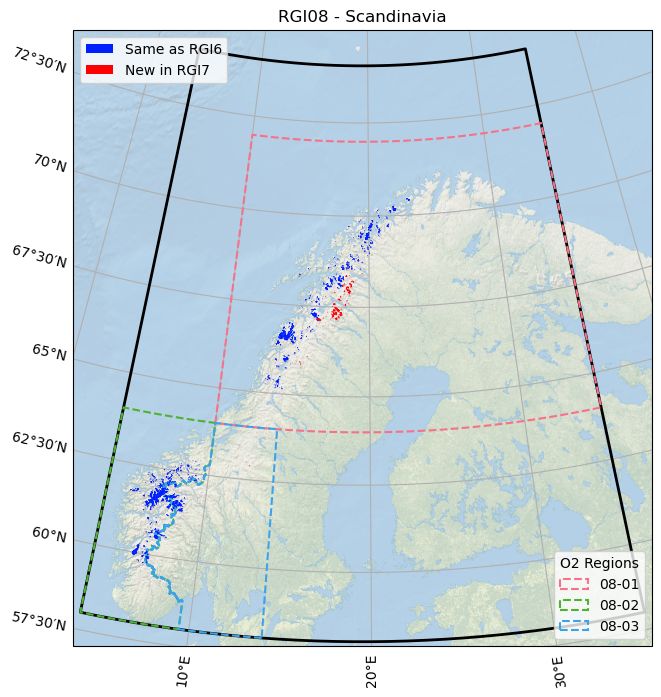

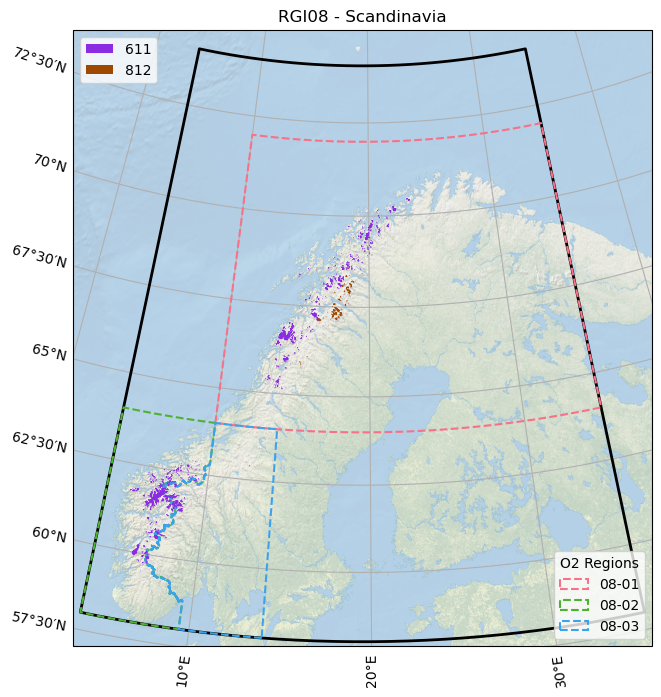

In [28]:
o2_cmap = sns.color_palette('husl', n_colors=len(srdf))
subm_cmap = sns.color_palette('bright')
color_order = [4, 5, 6, 8, 9, 2, 1, 0, 3, 7]

for is_rgi6 in [True, False]:
    
   
    # Prepare figure
    fig = plt.figure(figsize=region_params['figsize'])
    ax = fig.add_subplot(1, 1, 1, projection=map_crs)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    if reg_str == '19':
        import matplotlib.path as mpath
        theta = np.linspace(0, 2*np.pi, 100)
        map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])
        ax.set_boundary(map_circle, transform=ax.transAxes)
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, dms=True,  
                          xlocs=np.arange(9) * 45 - 180);
    else:
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, dms=True, 
                          xlocs=np.arange(37) * 10 - 180);
        gl.top_labels = False
        gl.right_labels = False
    
    # Add background
    ax.imshow(imread(region_params['background']), 
              origin='upper', 
              transform=ccrs.PlateCarree(), 
              extent=[-180, 180, -90, 90])
    
    # Plot o1 regions
    if reg_str != '19' or is_20:
        rdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=4, 
                                 linewidth=region_params['linewidth_o1'])
    
    # Plot o2 regions including legend 
    sr_handles = []
    for ind, row in srdf.reset_index().to_crs(map_crs).iterrows():
        ec = o2_cmap[ind]
        s_loc = srdf.to_crs(map_crs).loc[srdf['o2region'] == row['o2region']]
        s_loc.plot(ax=ax, facecolor='none', edgecolor=ec, zorder=5, linewidth=region_params['linewidth_o2'], ls='--')
        sr_handles.append(mpatches.Patch(facecolor='none', edgecolor=ec,
                                         linestyle='--', 
                                         linewidth=region_params['linewidth_o2'], 
                                         label=f'{row.o2region}'))

    sr_leg = ax.legend(handles=sr_handles, loc=region_params['o2_legend_loc'], title='O2 Regions')
    art = ax.add_artist(sr_leg)
    art.zorder = 99
    
    handles = []
    if not is_20:
        if is_rgi6:
            for itis in [True, False]:
                ec = '#001fff' if itis else '#ff0000'
                fc = '#465dff' if itis else '#ff4646'
                label = 'Same as RGI6' if itis else 'New in RGI7'
                s_loc = shp_repr.loc[shp_repr['is_rgi6'] == itis]
                if len(s_loc) > 0:
                    s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, 
                               linewidth=region_params['linewidth_outlines'], zorder=97)
                    area = s_loc['area_km2'].sum()
                else:
                    area = 0
                handles.append(mpatches.Patch(facecolor=ec, label=f'{label}'))
        else:
            for i, subid in enumerate(sorted(shp.subm_id.unique().astype(int))):
                fc = subm_cmap[color_order[i]]
                ec = fc # subm_cmap_ec[i]
                s_loc = shp_repr.loc[shp.subm_id == subid]
                s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, linewidth=region_params['linewidth_outlines'], zorder=97)
                area = s_loc['area_km2'].sum()
                handles.append(mpatches.Patch(facecolor=fc, label=f'{subid}'))

    # Alternative solution for "Polygon handles not passing to legend"
    try: 
        loc = region_params['o1_legend_loc_subm']
    except KeyError:
        loc = region_params['o1_legend_loc']
    if not is_20:
        ax.legend(handles=handles, loc=loc);
    ax.set_title(title);
    
    plotname = 'isrgi6_map' if is_rgi6 else 'inventory_map'
    plt.savefig(plot_dir + f'/{plotname}.jpeg', bbox_inches='tight', dpi=300)
    print(plot_dir + f'/{plotname}.jpeg')

In [29]:
! convert {plot_dir}/isrgi6_map.jpeg -resize 900 -quality 75 {plot_dir}/isrgi6_map_small.jpeg

In [30]:
! convert {plot_dir}/inventory_map.jpeg -resize 900 -quality 75 {plot_dir}/inventory_map_small.jpeg

### Histogram 

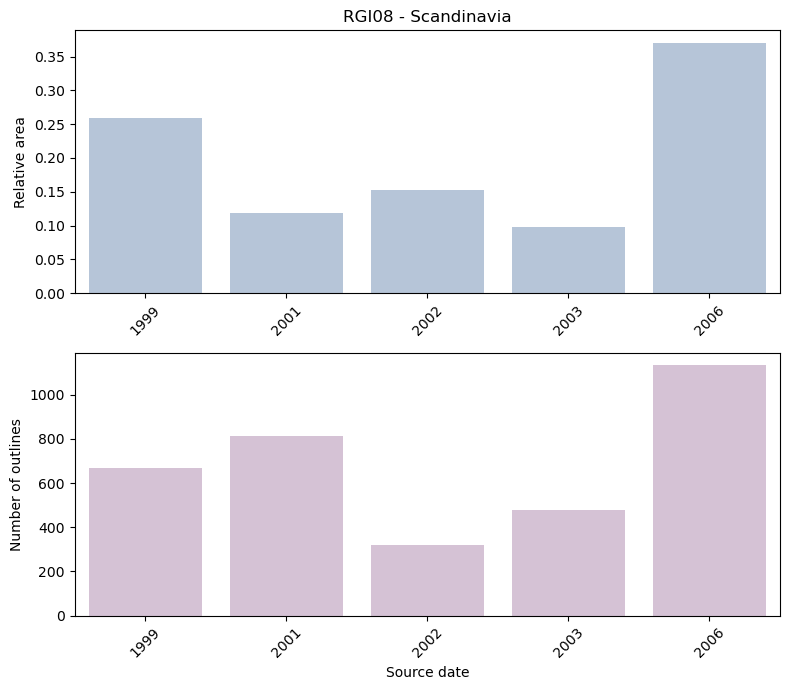

In [31]:
if not is_20:
    figsize=(8, 7)

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    date_i = shp['src_date'].str[:4].astype(int).to_frame('src_date')
    date_i['area'] = shp['area_km2']
    date = date_i.groupby('src_date')['area'].sum().to_frame()
    date['area'] = date['area'] / date['area'].sum()
    date['count'] =  date_i.groupby('src_date')['area'].count()
    date = date.reset_index()

    sns.barplot(ax=ax1, x='src_date', y='area', data=date, color='lightsteelblue');
    ax1.set_ylabel('Relative area'); ax1.set_xlabel(''); 
    ax1.set_title(title);
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)

    sns.barplot(ax=ax2, x='src_date', y='count', data=date, color='thistle');
    ax2.set_ylabel('Number of outlines'); ax2.set_xlabel('Source date'); 
    plt.xticks(rotation=45, ha='center')

    plotname = 'date_hist'
    plt.tight_layout()
    plt.savefig(plot_dir + f'/{plotname}.png', bbox_inches='tight', dpi=300)

## Attributes text 

In [32]:
from oggm.utils import file_downloader
rgi6 = pd.read_hdf(file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))
rgi6 = rgi6.loc[rgi6.Connect != 2].copy()
rgi6 = rgi6.loc[rgi6['O1Region'] == reg_str].copy()
rgi6['RGIId'] = rgi6.index

In [33]:
rgi7 = shp

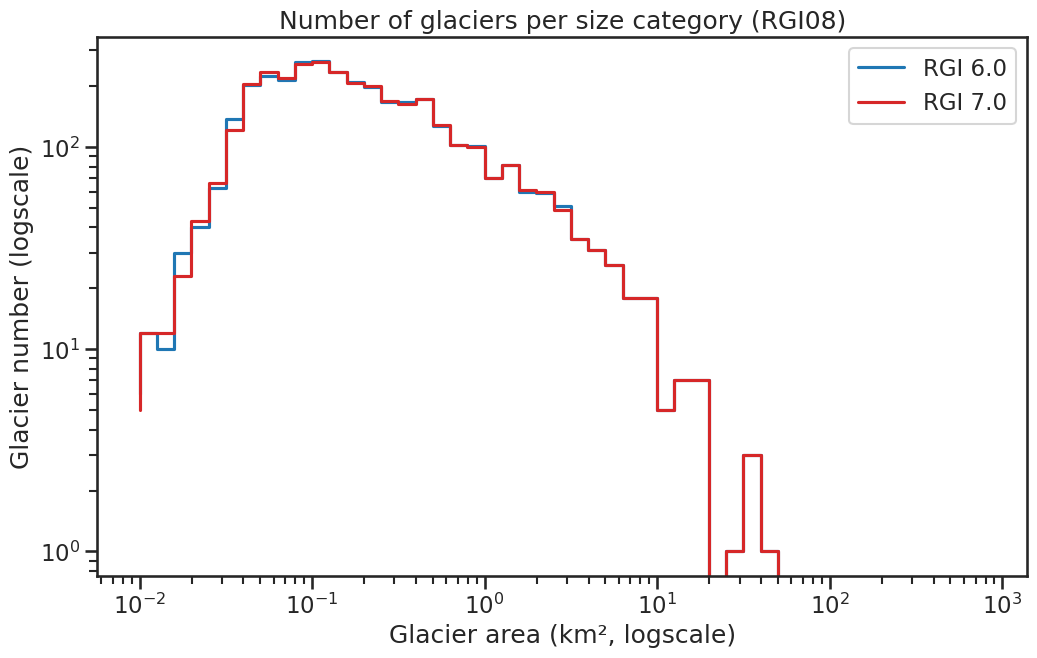

In [34]:
if not is_20:
    with sns.plotting_context('talk'), sns.axes_style('ticks'):

        bins = np.logspace(-2, 3, 51)

        h7, b7 = np.histogram(rgi7['area_km2'], bins=bins)
        h6, b6 = np.histogram(rgi6['Area'], bins=bins)

        f, ax = plt.subplots(figsize=(12, 7))
        ax.step(b6[:-1], h6, color='C0', label='RGI 6.0');
        ax.step(b7[:-1], h7, color='C3', label='RGI 7.0');
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.legend()
        ax.set_title(f'Number of glaciers per size category (RGI{reg_str})')
        ax.set_xlabel('Glacier area (km², logscale)');
        ax.set_ylabel('Glacier number (logscale)');
        plt.savefig(f'{plot_dir}/area_histogram.png', dpi=100, bbox_inches='tight')

In [35]:
rdf = pd.DataFrame(index=[0, 1, 2, 3, 9])
rdf.index.name = 'Value'
rdf['Terminus type'] = ['Land-terminating', 'Marine-terminating', 'Lake-terminating', 'Shelf-terminating', 'Not assigned']
rdf['RGI7 (N)'] = rgi7.groupby('term_type').count()['rgi_id']
rdf['RGI6 (N)'] = rgi6.groupby('TermType').count()['RGIId'].reset_index(drop=True)
rdf['RGI7 (Area)'] = rgi7.groupby('term_type')['area_km2'].sum().round(0).astype(int)
rdf['RGI6 (Area)'] = rgi6.groupby('TermType')['Area'].sum().round(0).reset_index(drop=True)
rdf = rdf.replace(np.NaN, 0)
rdf[['RGI7 (N)', 'RGI6 (N)']] = rdf[['RGI7 (N)', 'RGI6 (N)']].astype(int)
rdf[['RGI7 (Area)', 'RGI6 (Area)']] = rdf[['RGI7 (Area)', 'RGI6 (Area)']].astype(int)
rdf.columns = ['Terminus type', 'RGI 7.0 (N)', 'RGI 6.0 (N)', 'RGI 7.0 (Area)', 'RGI 6.0 (Area)']
rdf_t = rdf
rdf_t

Terminus type  RGI 7.0 (N)  RGI 6.0 (N)  RGI 7.0 (Area)  \
Value                                                                 
0        Land-terminating            0         3417               0   
1      Marine-terminating            0            0               0   
2        Lake-terminating            0            0               0   
3       Shelf-terminating            0            0               0   
9            Not assigned         3410            0            2948   

       RGI 6.0 (Area)  
Value                  
0                2949  
1                   0  
2                   0  
3                   0  
9                   0

In [36]:
rdf = pd.DataFrame(index=[0, 1, 2, 3, 9])
rdf.index.name = 'Value'
rdf['Surging'] = ['No evidence', 'Possible', 'Probable', 'Observed', 'Not assigned']
rdf['RGI7 (N)'] = rgi7.groupby('surge_type').count()['rgi_id']
rdf['RGI6 (N)'] = rgi6.groupby('Surging').count()['RGIId']
rdf['RGI7 (Area)'] = rgi7.groupby('surge_type')['area_km2'].sum().round(0).astype(int)
rdf['RGI6 (Area)'] = rgi6.groupby('Surging')['Area'].sum().round(0).astype(int)
rdf = rdf.replace(np.NaN, 0)
rdf[['RGI7 (N)', 'RGI6 (N)']] = rdf[['RGI7 (N)', 'RGI6 (N)']].astype(int)
rdf[['RGI7 (Area)', 'RGI6 (Area)']] = rdf[['RGI7 (Area)', 'RGI6 (Area)']].astype(int)
rdf.columns = ['Surge type', 'RGI 7.0 (N)', 'RGI 6.0 (N)', 'RGI 7.0 (Area)', 'RGI 6.0 (Area)']
rdf_s = rdf
rdf_s

Surge type  RGI 7.0 (N)  RGI 6.0 (N)  RGI 7.0 (Area)  RGI 6.0 (Area)
Value                                                                        
0       No evidence         3410            0            2948               0
1          Possible            0            0               0               0
2          Probable            0            0               0               0
3          Observed            0            0               0               0
9      Not assigned            0         3417               0            2949

In [37]:
text = f"""````{{admonition}} Regional statistics
:class: seealso, dropdown

```{{card}} Figure: Outlines source date

:::{{figure-md}}
<img src="../img/region_plots/RGI{reg_str}/date_hist.png" alt="region map" class="bg-primary mb-1">

Distribution of the outline dates per area (top) and number (bottom)
:::

```

```{{card}} Figure: Glacier area histogram

:::{{figure-md}}
<img src="../img/region_plots/RGI{reg_str}/area_histogram.png" alt="region histogram" class="bg-primary mb-1">

Number of glaciers per size category (log-log scale).
:::

```

```{{card}} Table: Terminus type statistics

Regional number of glaciers (N) and area (km²) per terminus type in RGI 7.0 and RGI 6.0. Note that the default designation in RGI 7.0 is now "Not assigned", while in RGI 6.0 lake-terminating glaciers and shelf-terminating glaciers were identified in some regions. The RGI region 19 is entirely labelled as "Not assigned" in RGI 7.0.

{rdf_t.to_markdown()}

```

```{{card}} Table: Surge type statistics

Regional number of glaciers (N) and area (km²) per surge type attribute in RGI 7.0 and RGI 6.0.

{rdf_s.to_markdown()}

```

````"""
# print(text)

In [38]:
start_line = "````{admonition} Regional statistics" 
end_line = "````" 
if not is_20:
    replace_text_between_lines(region_text_file, text, start_line, end_line)

## Attributes map 

In [39]:
# if not is_20:
#     for attr in ['term_type']:

#         print(f'Plot {attr}')

#         # Prepare figure
#         fig = plt.figure(figsize=region_params['figsize'])
#         ax = fig.add_subplot(1, 1, 1, projection=map_crs)
#         ax.set_extent(extent, crs=ccrs.PlateCarree())

#         if reg_str == '19':
#             import matplotlib.path as mpath
#             theta = np.linspace(0, 2*np.pi, 100)
#             map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])
#             ax.set_boundary(map_circle, transform=ax.transAxes)
#             gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, dms=True,  
#                               xlocs=np.arange(9) * 45 - 180);
#         else:
#             gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, dms=True, 
#                               xlocs=np.arange(37) * 10 - 180);
#             gl.top_labels = False
#             gl.right_labels = False

#         # Add background
#         # ax.imshow(imread(region_params['background']), 
#         #           origin='upper', 
#         #           transform=ccrs.PlateCarree(), 
#         #           extent=[-180, 180, -90, 90])

#         # Plot o1 regions
#         if reg_str != '19' or is_20:
#             rdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=4, 
#                                      linewidth=region_params['linewidth_o1'])

#         sr_leg = ax.legend(handles=sr_handles, loc=region_params['o2_legend_loc'], title='O2 Regions')
#         art = ax.add_artist(sr_leg)
#         art.zorder = 99

#         ec = '#001fff' if itis else '#ff0000'
#         fc = '#465dff' if itis else '#ff4646'
#             shp_repr.plot(ax=ax, facecolor=fc, edgecolor=ec, 
#                           linewidth=region_params['linewidth_outlines'], zorder=97)

#         ax.set_title(title);

#         plot_dir = data_dir + f'/l4_rgi7b0_plots/RGI{reg:02d}'
#         mkdir(plot_dir)
#         plotname = 'isrgi6_map' if is_rgi6 else 'inventory_map'
#         plt.savefig(plot_dir + f'/{plotname}.jpeg', bbox_inches='tight', dpi=300)